In [1]:
%load_ext autoreload
%autoreload 2

# PriorCVAE reimplementation

For a 1D GP, reimplementing all the plots in Liza's 011 notebook.

In [2]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

In [3]:
numpyro.set_host_device_count(3)

In [4]:
from reusable.kernels import esq_kernel

args = {
    # GP prior configuration
    "n": 100,
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}
args.update({ # so we can use the definition of n to define x
    
    "x": jnp.arange(0, 1, 1/args["n"]),

    "conditional": True,

    # VAE configuration
    "hidden_dim1": 35,
    "hidden_dim2": 32,
    "latent_dim": 30,
    "vae_var": 0.1,

    # learning
    "num_epochs": 50,
    "learning_rate": 1.0e-3,
    "batch_size": 100,
    "train_num_batches": 200,
    "test_num_batches": 200,

    # MCMC parameters
    "num_warmup": 1000,
    "num_samples": 1000,
    "thinning": 1,
    "num_chains": 3,

    "pretrained_vae": False


})

rng_key, _ = random.split(random.PRNGKey(4))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Examples of priors to encode

Long lengthscales, with ls=0.4

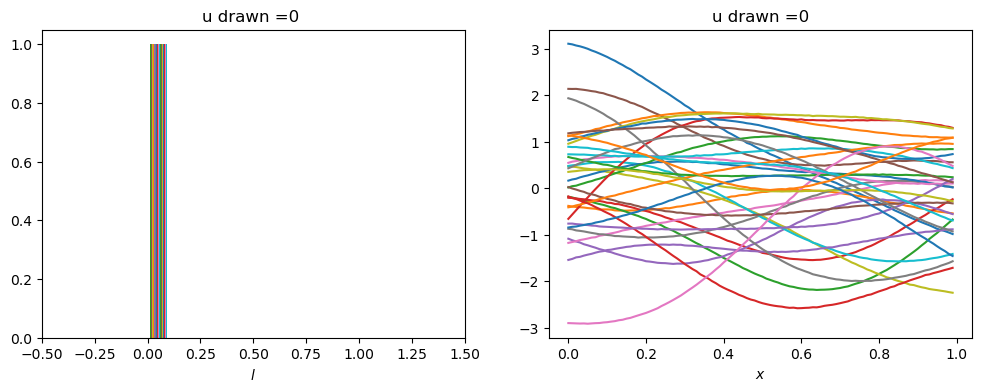

In [5]:
from reusable.gp import OneDGP_BinaryCond
from plotting.plots import plot_lengthscales, plot_draws

rng_key, rng_key_long, rng_key_short, rng_key_both = random.split(rng_key, 4)

long = Predictive(OneDGP_BinaryCond, num_samples=50)
long_samples = long(rng_key_long, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5, u=0)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
plot_lengthscales(long_samples["u"], title="u drawn =0 ", ax=axs[0])
plot_draws(long_samples["y"], args["x"],  title="u drawn =0", ylabel="", ax=axs[1])


Short lengthscales, with ls=0.1

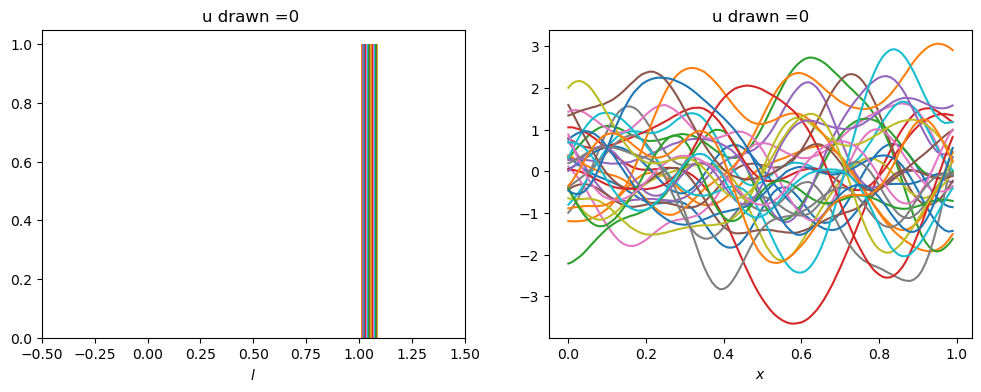

In [7]:

short = Predictive(OneDGP_BinaryCond, num_samples=50)
short_samples = short(rng_key_short, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5, u=1)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
plot_lengthscales(short_samples["u"], title="u drawn =0 ", ax=axs[0])
plot_draws(short_samples["y"], args["x"],  title="u drawn =0", ylabel="", ax=axs[1])

Both lengthscales, together

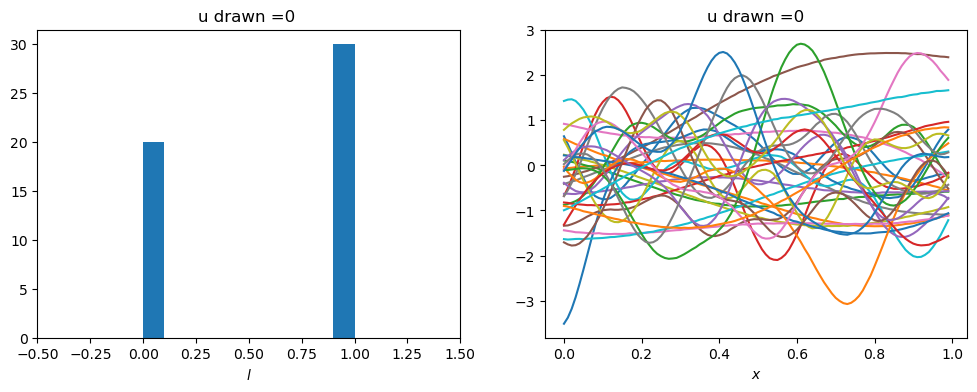

In [8]:
both = Predictive(OneDGP_BinaryCond, num_samples=50)
both_samples = both(rng_key_both, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
plot_lengthscales(both_samples["u"], title="u drawn =0 ", ax=axs[0])
plot_draws(both_samples["y"], args["x"],  title="u drawn =0", ylabel="", ax=axs[1])

[-0.5034884  -0.6308117  -0.7590581  -0.87883896 -0.996238   -1.1030177
 -1.1979989  -1.2658926  -1.3256208  -1.3538387  -1.3521582  -1.3374423
 -1.2869958  -1.2200258  -1.1318519  -1.0313488  -0.92629904 -0.804453
 -0.6896938  -0.57381284 -0.47661206 -0.4119966  -0.34683046 -0.31435382
 -0.3106969  -0.32192954 -0.36304823 -0.43185097 -0.50862074 -0.59978837
 -0.69549996 -0.7974851  -0.8976511  -0.9961478  -1.0908957  -1.1776263
 -1.2498482  -1.3222972  -1.3921645  -1.46368    -1.5399525  -1.6016243
 -1.6756963  -1.7448944  -1.8210431  -1.8796699  -1.9337302  -1.9684408
 -1.9770612  -1.9670103  -1.9189987  -1.8295654  -1.7224178  -1.5737417
 -1.3852111  -1.1790655  -0.9331521  -0.68718237 -0.42695212 -0.18082185
  0.06036507  0.27191836  0.4588796   0.6068056   0.7127196   0.780075
  0.79184437  0.7802027   0.72391987  0.64016694  0.5407778   0.41485858
  0.29342613  0.16249982  0.04904677 -0.05772617 -0.14564945 -0.20761682
 -0.2509629  -0.2620194  -0.24138607 -0.19364281 -0.10726155 

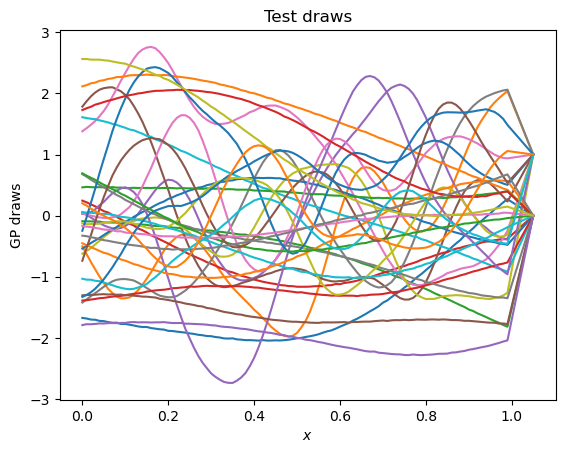

In [46]:
if not args["pretrained_vae"]:
    from reusable.gp import OneDGP_BinaryCond
    from reusable.train_nn import gen_gp_batches

    
    rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
    # generate a complete set of training and test data

    # NOTE changed draw_access - y_c is [y,u] for this
    train_draws = gen_gp_batches(args["x"], OneDGP_BinaryCond, args["gp_kernel"], args["train_num_batches"], args["batch_size"], rng_key_train, draw_access="y_c")
    test_draws = gen_gp_batches(args["x"], OneDGP_BinaryCond, args["gp_kernel"], 1, args["test_num_batches"]* args["batch_size"], rng_key_test, draw_access="y_c")
    
    from plotting.plots import plot_draws
    print(train_draws[4,1])
    plot_draws(train_draws[4], jnp.append(args["x"], 1.05), "Test draws", "GP draws")

In [70]:
from reusable.vae import VAE
from reusable.train_nn import SimpleTrainState
import optax

rng_key, rng_key_init, rng_key_train = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=True,
)
params = module.init(rng_key, jnp.ones((args["batch_size"], args["n"]+1,)))["params"]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key = rng_key_init)


(100, 101) (100, 100) 100


In [77]:
import optax
import jax


@jax.jit
def calculate_loss(y, reconstructed_y, mean, log_sd):
    # note doesn't divide by n
    # NOTE: have to remove the conditional label!
    RCL = jnp.sum(optax.l2_loss(reconstructed_y, y[:, :-1]))  # change this to log-likelihood
    KLD = -0.5 * jnp.sum(1 + log_sd - jnp.power(mean, 2) - jnp.exp(log_sd))

    return RCL + KLD




epoch: 1, {'train_loss': Array(1426.6289, dtype=float32), 'train_avg_loss': Array(1436.0756, dtype=float32), 'test_loss': Array(290347.12, dtype=float32)}
epoch: 6, {'train_loss': Array(1422.7825, dtype=float32), 'train_avg_loss': Array(1432.3453, dtype=float32), 'test_loss': Array(289120.53, dtype=float32)}
epoch: 11, {'train_loss': Array(1246.7527, dtype=float32), 'train_avg_loss': Array(1330.9856, dtype=float32), 'test_loss': Array(257559.58, dtype=float32)}
epoch: 16, {'train_loss': Array(1269.6765, dtype=float32), 'train_avg_loss': Array(1282.2418, dtype=float32), 'test_loss': Array(259660.58, dtype=float32)}
epoch: 21, {'train_loss': Array(1270.492, dtype=float32), 'train_avg_loss': Array(1282.008, dtype=float32), 'test_loss': Array(258819.53, dtype=float32)}
epoch: 26, {'train_loss': Array(1249.2747, dtype=float32), 'train_avg_loss': Array(1272.6163, dtype=float32), 'test_loss': Array(254204.81, dtype=float32)}
epoch: 31, {'train_loss': Array(1269.3866, dtype=float32), 'train_av

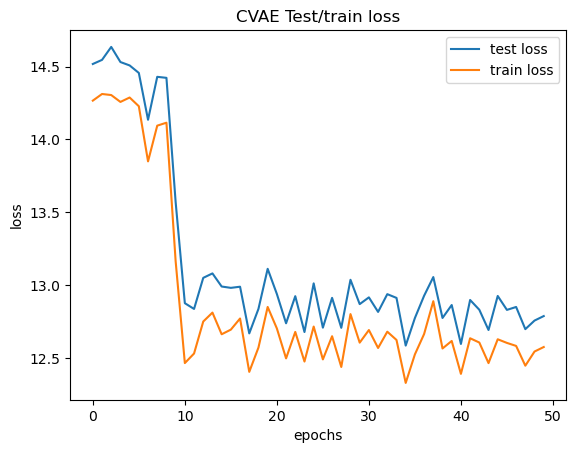

In [84]:
if not args["pretrained_vae"]:
    from reusable.train_nn import run_training

    state, metrics_history = run_training(calculate_loss, lambda *_: {}, args["num_epochs"], train_draws, test_draws, state)

    from plotting.plots import plot_training

    plot_training(metrics_history["test_loss"]/(args["batch_size"] * args["test_num_batches"]), metrics_history["train_loss"]/args["batch_size"], "CVAE Test/train loss", note="loss")


### Training progress

comment 09/02/2023: why is there a shelf in the loss?, also, why is our test loss so closer to train loss?

In [85]:
from flax.core.frozen_dict import freeze
from reusable.util import decoder_filename, get_savepath

file_path = f'{get_savepath()}/{decoder_filename("03", args)}'

if not args["pretrained_vae"]:
    decoder_params = freeze({"params": state.params["VAE_Decoder_0"]})
    args["decoder_params"] = decoder_params
    with open(file_path, 'wb') as file:
       file.write(serialization.to_bytes(decoder_params))

if args["pretrained_vae"]:
    from reusable.vae import VAE_Decoder
    dummy_decoder = VAE_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"], conditional=True)
    dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))
    with open(file_path, 'rb') as file:
        bytes = file.read()
        
        args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

## Demonstrations

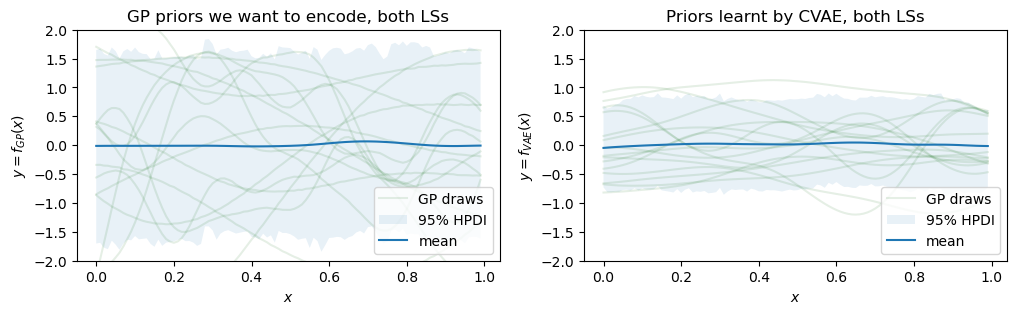

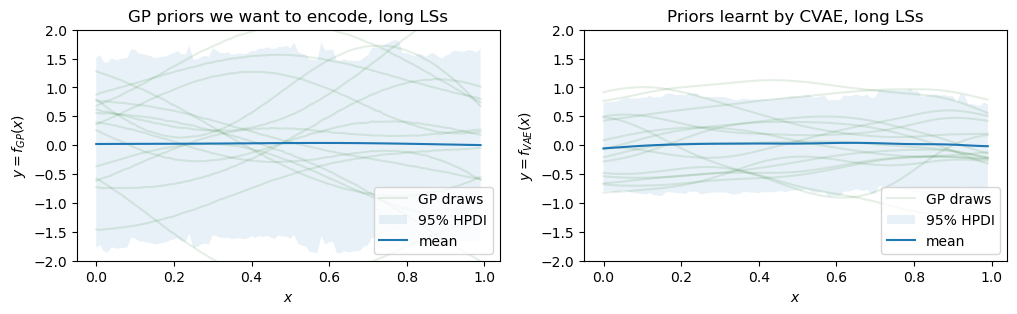

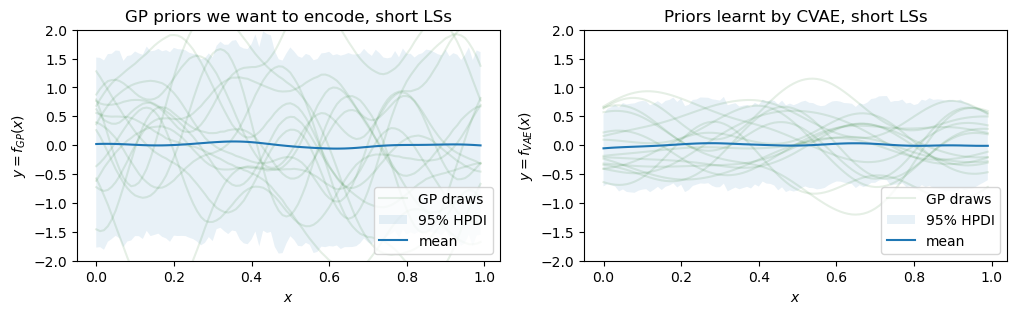

In [90]:
from reusable.vae import cvae_sample
from plotting.plots import compare_draws
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

conditions = [(None, "both"), (0, "long"), (1, "short")]
for cond, label in conditions:

    plot_gp_predictive = Predictive(OneDGP_BinaryCond, num_samples=1000)
    gp_draws = plot_gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5, u=cond)['y']

    plot_vae_predictive = Predictive(cvae_sample, num_samples=1000)
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
        condition=cond
    )["f"]

    compare_draws(args["x"], gp_draws, vae_draws, f"GP priors we want to encode, {label} LSs", f"Priors learnt by CVAE, {label} LSs", '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$', save_path="gen_plots/02_prior_comp_both.png")


# Inference

In [118]:
import os


def run_mcmc_cvae(rng_key, model_mcmc, y_obs, obs_idx, c=None, binary_prior=True, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(
        rng_key,
        args["hidden_dim1"],
        args["hidden_dim2"],
        args["latent_dim"],
        args["n"],
        args["decoder_params"],
        y=y_obs,
        obs_idx=obs_idx,
        c=c,
        binary_prior=binary_prior
    )
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()


Ground truth, c=1

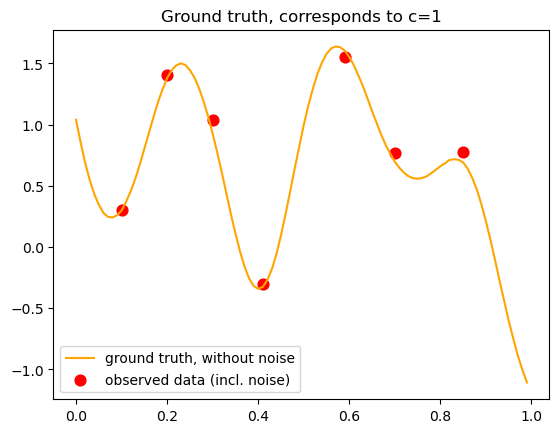

In [111]:
from reusable.gp import OneDGP_BinaryCond
rng_key_ground_truth = random.PRNGKey(
    4
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(OneDGP_BinaryCond, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-6, noise=True, u=1
)
ground_truth = gt_draws["f"].T
ground_truth_y_draw = gt_draws["y"].T

obs_idx = jnp.array([10, 20, 30, 41, 59, 70, 85])
gt_y_obs = ground_truth_y_draw[obs_idx, 0]
x_obs = args["x"][obs_idx]

plt.plot(args["x"], ground_truth, label="ground truth, without noise", color="orange")
plt.scatter(x_obs, gt_y_obs, color="red", label="observed data (incl. noise)", s=60)
plt.title('Ground truth, corresponds to c=1')
plt.legend()

## Inference: assume correct LS

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 4.81759786605835


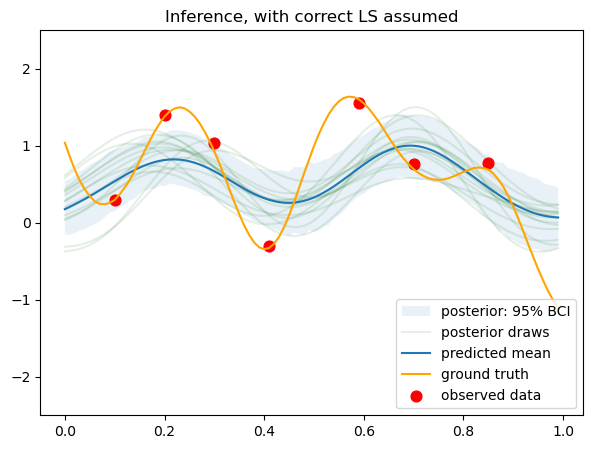

In [114]:
from reusable.vae import cvae_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_cvae(rng_key_post, cvae_mcmc, gt_y_obs, obs_idx, c=1)

predictive = Predictive(cvae_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"], c=1)["f"]

from plotting.plots import plot_one_inference

plot_one_inference(args["x"], ground_truth, x_obs, gt_y_obs, predictions, "Inference, with correct LS assumed")

## Inference: assume wrong LS

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 4.2248311042785645


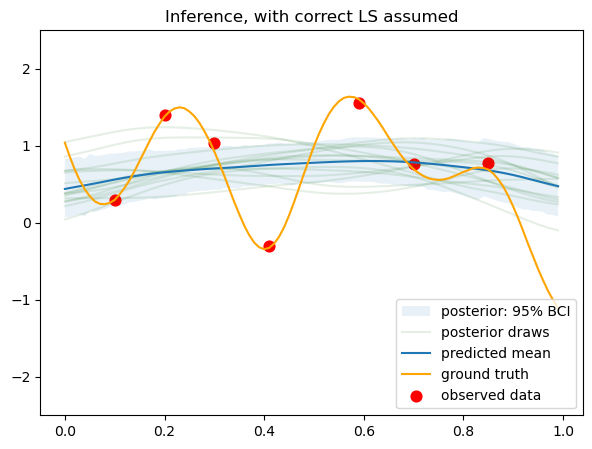

In [115]:
from reusable.vae import cvae_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_cvae(rng_key_post, cvae_mcmc, gt_y_obs, obs_idx, c=0)

predictive = Predictive(cvae_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"], c=0)["f"]

from plotting.plots import plot_one_inference

plot_one_inference(args["x"], ground_truth, x_obs, gt_y_obs, predictions, "Inference, with incorrect LS assumed")

## Inference: unknown LS (note Beta prior!)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 7.208230972290039


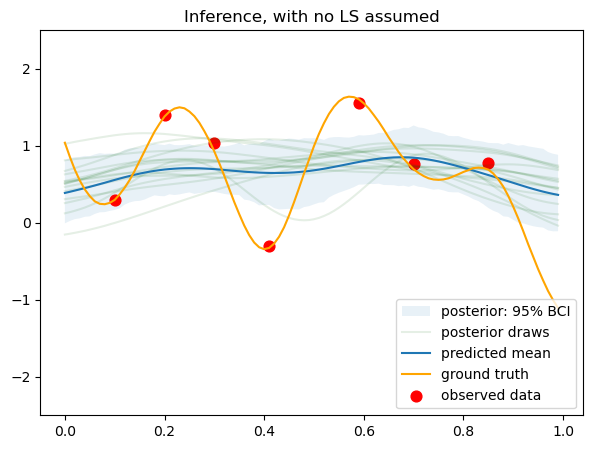

In [120]:
from reusable.vae import cvae_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_cvae(rng_key_post, cvae_mcmc, gt_y_obs, obs_idx, c=None, binary_prior=False)

predictive = Predictive(cvae_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"], c=None, binary_prior=False)["f"]

from plotting.plots import plot_one_inference

plot_one_inference(args["x"], ground_truth, x_obs, gt_y_obs, predictions, "Inference, with no LS assumed")

# Posterior of lengthscale condition

Text(0.5, 1.0, 'c - posterior samples')

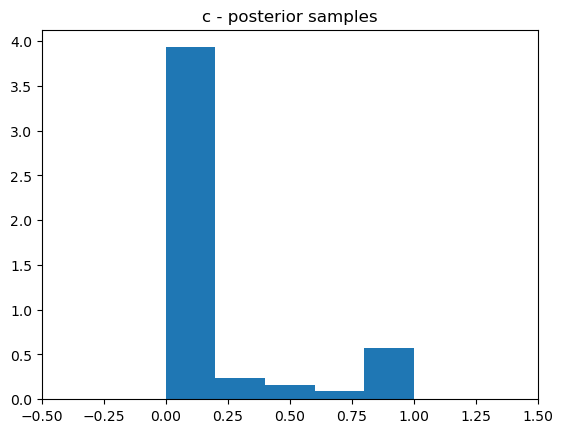

In [121]:
c_samps = mcmc_samples['c']
plt.hist(c_samps, density=True, bins=5) 
plt.xlim(-0.5,1.5)
plt.title('c - posterior samples')

# To do:

- attempt MCMC with funsor
- MixedHMC for discrete prior
- covariance matrices?